In [1]:
import sys
import os
sys.path.append(os.environ["BUILD_WORKSPACE_DIRECTORY"])
from torch import nn
import torchvision.models as models
import torch
torch.manual_seed(0)
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from datetime import datetime
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import json
import wandb
from torch.utils.data import WeightedRandomSampler
from autoaugment.autoaugment import ImageNetPolicy

ModuleNotFoundError: No module named 'autoaugment'

In [2]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [3]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict


def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for _,j in dataloader_obj:
        y_idx = j.item()
        y_lbl = idx2class[y_idx]
        count_dict[str(y_lbl)] += 1
            
    return count_dict
def get_class_target_list_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    target = []
    for _,j in dataloader_obj:
        y_idx = j.item()
        target.append(y_idx)
            
    return target

In [4]:
class SelfAttention(nn.Module):
    
    def __init__(self,input_dim):
        super(SelfAttention,self).__init__()
        self.to_query = nn.Conv2d(in_channels = input_dim , out_channels = input_dim//8 , kernel_size= 1)
        self.to_key = nn.Conv2d(in_channels = input_dim , out_channels = input_dim//8 , kernel_size= 1)
        self.to_value = nn.Conv2d(in_channels = input_dim , out_channels = input_dim , kernel_size= 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1) #
    
    def forward(self,x):
        bs, c, w, h = x.size()
        Q  = self.to_query(x).view(bs, -1, w * h).permute(0,2,1) 
        K =  self.to_key(x).view(bs,-1,w * h)
        E =  torch.bmm(Q,K) 
        A = self.softmax(E) 
        V = self.to_value(x).view(bs, -1, w * h) 
        Y = torch.bmm(V, A.permute(0,2,1))
        Y = Y.view(bs, c, w, h)
        out = self.gamma * Y + x
        return out, A
    
class AttentionResnet50(nn.Module):
    
    def __init__(self, num_classes):
        super(AttentionResnet50,self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.att_1 = SelfAttention(512)
        self.att_2 = SelfAttention(1024)
        self.att_3 = SelfAttention(2048)
        self.dropout=nn.Dropout(0.2)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self,x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x, _ = self.att_1(x)
        x = self.dropout(x)
        x = self.resnet.layer3(x)
        x, _ = self.att_2(x)
        x = self.dropout(x)
        x = self.resnet.layer4(x)
        x, _ = self.att_3(x)
        x = self.dropout(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.resnet.fc(x)
        return x

In [5]:
class MapDataset(Dataset):

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)

#### Focal loss based on https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from typing import Optional

def one_hot(
    labels: torch.Tensor,
    num_classes: int,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
    eps: float = 1e-6,
) -> torch.Tensor:
    if not isinstance(labels, torch.Tensor):
        raise TypeError(f"Input labels type is not a torch.Tensor. Got {type(labels)}")

    if not labels.dtype == torch.int64:
        raise ValueError(f"labels must be of the same dtype torch.int64. Got: {labels.dtype}")

    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one." " Got: {}".format(num_classes))

    shape = labels.shape
    one_hot = torch.zeros((shape[0], num_classes) + shape[1:], device=device, dtype=dtype)

    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps


def focal_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    alpha: float,
    gamma: float = 2.0,
    reduction: str = 'none',
    eps: Optional[float] = None,
) -> torch.Tensor:
    if eps is not None and not torch.jit.is_scripting():
        warnings.warn(
            "`focal_loss` has been reworked for improved numerical stability "
            "and the `eps` argument is no longer necessary",
            DeprecationWarning,
            stacklevel=2,
        )

    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f'Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).')

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError(f'Expected target size {out_size}, got {target.size()}')

    if not input.device == target.device:
        raise ValueError(f"input and target must be in the same device. Got: {input.device} and {target.device}")

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1)
    log_input_soft: torch.Tensor = F.log_softmax(input, dim=1)

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)

    focal = -alpha * weight * log_input_soft
    loss_tmp = torch.einsum('bc...,bc...->b...', (target_one_hot, focal))

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss

class FocalLoss(nn.Module):

    def __init__(self, alpha: float, gamma: float = 2.0, reduction: str = 'none', eps: Optional[float] = None) -> None:
        super().__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: Optional[float] = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

## Please Change the optimizer learning parameters below

In [7]:
def train_model(model, config, dataloaders, dataset_sizes, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = FocalLoss(alpha = 0.25, gamma = 1.5, reduction = 'mean') # nn.CrossEntropyLoss() #FocalLoss(alpha = 0.25, gamma = 1.5, reduction = 'mean') #nn.CrossEntropyLoss()
    model_path = './models'
#     optimizer = torch.optim.Adam([{'params': [param for name, param in model.named_parameters() if 'att' not in name]},
#                               {'params': model.att_1.parameters(), 'lr': 1 * config['learning_rate']}, 
#                               {'params': model.att_2.parameters(), 'lr': 1 * config['learning_rate']}, 
#                               {'params': model.att_3.parameters(), 'lr': 1 * config['learning_rate']}], lr=config['learning_rate'])
    
    wandb.init(project =  "attention_ppe_classification", entity = "voxel-wandb", config = config, tags = [config['tags']])
    config = wandb.config
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['step'], gamma=0.1)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())   
    best_f1 = 0
    model.to(device)
    for epoch in range(config.num_epochs):
        print('Epoch {}/{}'.format(epoch, config.num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_tp = 0
            running_fp = 0
            running_fn = 0
            #running_tn = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).view(-1)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_tp += torch.sum(np.logical_and(preds.cpu(),labels.data.cpu())).cuda()
                running_fp += torch.sum(np.greater(preds.cpu(),labels.data.cpu())).cuda()
                running_fn += torch.sum(np.less(preds.cpu(),labels.data.cpu())).cuda()                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            epoch_precision = running_tp/(running_tp+running_fp)
            epoch_recall = running_tp/(running_tp+running_fn)
            epoch_f1 = 2*(epoch_precision*epoch_recall)/(epoch_precision+epoch_recall)
            if phase == 'val':
                print("val loss", epoch_loss)
                print("val_f1", epoch_f1)
                wandb.log({"val loss":epoch_loss})
                wandb.log({"val_f1":epoch_f1})
            if phase == 'train':
                print("train loss", epoch_loss)
                wandb.log({"train loss":epoch_loss})

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc,epoch_precision,epoch_recall, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_f1))


    with open("./best_f1.txt","w") as f:
        f.write(str(float(best_f1)))
    f.close()
    # load best model weights
    model.load_state_dict(best_model_wts)

    #save this model
    example_input = torch.randn(1, 3, 224, 224, requires_grad=False).to(device)
    traced_model = torch.jit.trace(model, example_input)
    today_date = datetime.today().strftime('%Y-%m-%d')
    traced_model.save(f'{model_path}/voxel_classifier_resnet50_{config.tags}_{today_date}.pth')
    wandb.join()
    return model


## Running on dataset V2 Without Samling

In [ ]:
data_transforms = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('/home/reza_voxelsafety_com/experiments/ppe_classifaction/data/v2/vestdataset',
transform=data_transforms)
class_names = dataset.classes

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:

# Get a batch of training data
inputs, classes = next(iter(dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4])

imshow(out, title=[class_names[x] for x in classes[0:4]])

In [ ]:
num_val= int(len(dataset) * 0.2)
num_train = len(dataset) - num_val
train, val = random_split(dataset, [num_train, num_val])
batch_size = 128
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8),
    'val': DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8),
}
dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)
print(dataset_sizes)

### Define model and optimizer

In [ ]:
model = AttentionResnet50(2)

config = {
        'num_epochs': 15,
        'learning_rate': 1e-2,
        'step':7,
        'tags': "AttentionV2"
}
optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
train_model(model, config, dataloaders, dataset_sizes, optimizer)

## Running on dataset V2 With Samling

In [8]:
np.random.seed(0)
data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop((224,224),scale=(0.7,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

dataset = datasets.ImageFolder('/home/reza_voxelsafety_com/experiments/ppe_classifaction/data/v2/vestdataset')
class_names = dataset.classes
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, valid_idx)
train = MapDataset(train, data_transforms['train'])
val =  MapDataset(val, data_transforms['val'])
dataloaders = {             
    'train': DataLoader(train, batch_size=1, shuffle=False, num_workers=8),
    'val': DataLoader(val, batch_size=1, shuffle=False, num_workers=8),
}

In [9]:
dataset.class_to_idx
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx2class)

{0: 'no_vest', 1: 'vest'}


In [10]:
class_count =  get_class_distribution(dataset)

In [11]:
val_count = get_class_distribution_loaders(dataloaders['val'], dataset)

In [12]:
train_count = get_class_distribution_loaders(dataloaders['train'], dataset)


Text(0.5, 1.0, 'Val')

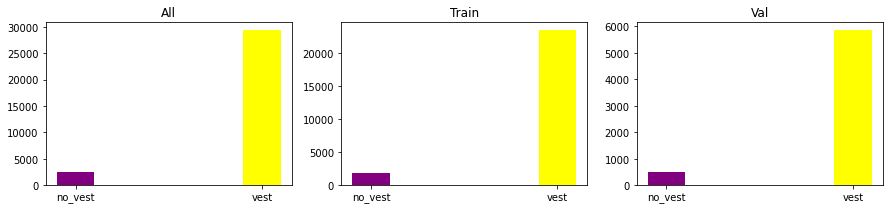

In [13]:
f = plt.figure(figsize=(15,3))
ax0 = f.add_subplot(131)
ax1 = f.add_subplot(132)
ax2 = f.add_subplot(133)
ax0.bar(class_count.keys(), class_count.values(), width = 0.2, color=['purple', 'yellow'])
ax0.set_title("All")
ax1.bar(train_count.keys(), train_count.values(), width = 0.2, color=['purple', 'yellow'])
ax1.set_title("Train")
ax2.bar(val_count.keys(), val_count.values(), width = 0.2, color=['purple', 'yellow'])
ax2.set_title("Val")

### Train Sampler

In [14]:
target_list_train = torch.tensor(get_class_target_list_loaders(dataloaders['train'], dataset))
class_count_train = [i for i in get_class_distribution_loaders(dataloaders['train'], dataset).values()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float) 
print(class_weights_train)
class_weights_train_all = class_weights_train[target_list_train]
print(len(class_weights_train_all))


tensor([5.1440e-04, 4.2560e-05])
25440


In [15]:
weighted_sampler_train = WeightedRandomSampler(
    weights=class_weights_train_all,
    num_samples=len(class_weights_train_all),
    replacement=True
)

### Val Sampler not needed

In [33]:
target_list_val = torch.tensor(get_class_target_list_loaders(dataloaders['val'], dataset))
print(target_list_val)
class_count_val = [i for i in get_class_distribution_loaders(dataloaders['val'], dataset).values()]
class_weights_val = 1./torch.tensor(class_count_val, dtype=torch.float) 
print(class_weights_val)
class_weights_val_all = class_weights_val[target_list_val]
print(len(class_weights_val_all))
weighted_sampler_val = WeightedRandomSampler(
    weights=class_weights_val_all,
    num_samples=len(class_weights_val_all),
    replacement=True
)

tensor([1, 1, 1,  ..., 1, 1, 1])
tensor([0.0020, 0.0002])
6359


In [16]:
batch_size = 128
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, num_workers=8, sampler=weighted_sampler_train),
    'val': DataLoader(val, batch_size=batch_size, num_workers=8),
}

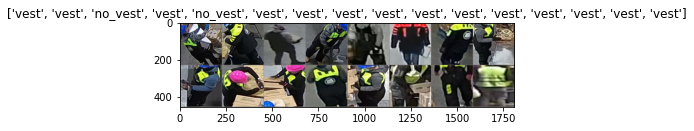

In [17]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[0:16])
imshow(out, title=[class_names[x] for x in classes[0:16]])

In [19]:
dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)
dataset_sizes

{'train': 25440, 'val': 6359}

In [20]:
model = AttentionResnet50(2)
config = {
        'num_epochs': 15,
        'learning_rate': 1e-2,
        'step':7,
        'tags': "AttentionV2SamplerFocalLossWithoutFormFitnessGamma1point5"
}

optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
train_model(model, config, dataloaders, dataset_sizes, optimizer)

wandb: Currently logged in as: voxel-wandb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0/14
----------


/home/reza_voxelsafety_com/.cache/bazel/_bazel_reza_voxelsafety_com/d620f0b6d4b41da06538aa48e57dfab6/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss 0.009533048863669142
train Loss: 0.0095 Acc: 0.9607 Precision: 0.9603 Recall: 0.9602 F1: 0.9603
val loss 0.012163208961020496
val_f1 tensor(0.9730, device='cuda:0')
val Loss: 0.0122 Acc: 0.9514 Precision: 0.9984 Recall: 0.9488 F1: 0.9730
Epoch 1/14
----------
train loss 0.002929166893463043
train Loss: 0.0029 Acc: 0.9908 Precision: 0.9937 Recall: 0.9882 F1: 0.9909
val loss 0.013591895247691691
val_f1 tensor(0.9736, device='cuda:0')
val Loss: 0.0136 Acc: 0.9525 Precision: 0.9987 Recall: 0.9497 F1: 0.9736
Epoch 2/14
----------
train loss 0.0018174785307210244
train Loss: 0.0018 Acc: 0.9946 Precision: 0.9968 Recall: 0.9924 F1: 0.9946
val loss 0.008576107379818697
val_f1 tensor(0.9822, device='cuda:0')
val Loss: 0.0086 Acc: 0.9676 Precision: 0.9982 Recall: 0.9666 F1: 0.9822
Epoch 3/14
----------
train loss 0.0011975162891369408
train Loss: 0.0012 Acc: 0.9967 Precision: 0.9984 Recall: 0.9951 F1: 0.9968
val loss 0.0076108408650920265
val_f1 tensor(0.9839, device='cuda:0')
val Loss

train loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val loss,▇█▄▃▃▃▂▂▂▂▂▁▂▁▁
val_f1,▁▁▅▆▆▆▇▇▇▇▇█▇██
train loss,0.00053
val loss,0.00569
val_f1,0.98899


AttentionResnet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

## HH Classifier

In [14]:
np.random.seed(0)
data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                ImageNetPolicy(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

dataset = datasets.ImageFolder('/home/reza_voxelsafety_com/experiments/ppe_classifaction/data/v2/hatdataset')
class_names = dataset.classes
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train = torch.utils.data.Subset(dataset, train_idx)
val = torch.utils.data.Subset(dataset, valid_idx)
train = MapDataset(train, data_transforms['train'])
val =  MapDataset(val, data_transforms['val'])
dataloaders = {
    'train': DataLoader(train, batch_size=1, shuffle=False, num_workers=8),
    'val': DataLoader(val, batch_size=1, shuffle=False, num_workers=8),
}

{0: 'hat', 1: 'no_hat'}


Text(0.5, 1.0, 'Val')

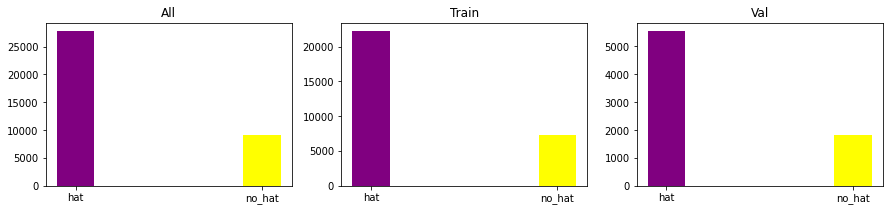

In [15]:
dataset.class_to_idx
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
print(idx2class)
class_count =  get_class_distribution(dataset)
val_count = get_class_distribution_loaders(dataloaders['val'], dataset)
train_count = get_class_distribution_loaders(dataloaders['train'], dataset)
f = plt.figure(figsize=(15,3))
ax0 = f.add_subplot(131)
ax1 = f.add_subplot(132)
ax2 = f.add_subplot(133)
ax0.bar(class_count.keys(), class_count.values(), width = 0.2, color=['purple', 'yellow'])
ax0.set_title("All")
ax1.bar(train_count.keys(), train_count.values(), width = 0.2, color=['purple', 'yellow'])
ax1.set_title("Train")
ax2.bar(val_count.keys(), val_count.values(), width = 0.2, color=['purple', 'yellow'])
ax2.set_title("Val")

tensor([4.4837e-05, 1.3768e-04])
29566


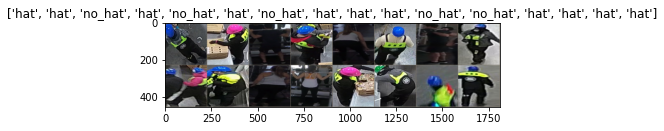

In [16]:
target_list_train = torch.tensor(get_class_target_list_loaders(dataloaders['train'], dataset))
class_count_train = [i for i in get_class_distribution_loaders(dataloaders['train'], dataset).values()]
class_weights_train = 1./torch.tensor(class_count_train, dtype=torch.float) 
print(class_weights_train)
class_weights_train_all = class_weights_train[target_list_train]
print(len(class_weights_train_all))
weighted_sampler_train = WeightedRandomSampler(
    weights=class_weights_train_all,
    num_samples=len(class_weights_train_all),
    replacement=True
)
batch_size = 128
dataloaders = {
    'train': DataLoader(train, batch_size=batch_size, num_workers=8, sampler=weighted_sampler_train),
    'val': DataLoader(val, batch_size=batch_size, num_workers=8),
}
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[0:16])
imshow(out, title=[class_names[x] for x in classes[0:16]])

In [17]:
dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)
dataset_sizes

{'train': 29566, 'val': 7391}

In [18]:
#model = AttentionResnet50(2)

model = torchvision.models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
config = {
        'num_epochs': 15,
        'learning_rate': 1e-2,
        'step':7,
        'tags': "HHVanilaV2SamplerFLGamma2"
}

optimizer = torch.optim.SGD(model.fc.parameters(), lr=config['learning_rate'], momentum=0.9)
train_model(model, config, dataloaders, dataset_sizes, optimizer)

wandb: Currently logged in as: voxel-wandb (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 0/14
----------


/home/reza_voxelsafety_com/.cache/bazel/_bazel_reza_voxelsafety_com/d620f0b6d4b41da06538aa48e57dfab6/execroot/voxel/bazel-out/k8-fastbuild/bin/third_party/jupyter/jupyter.runfiles/pip_deps_torch/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss 0.005487439661299812
train Loss: 0.0055 Acc: 0.9724 Precision: 0.9793 Recall: 0.9654 F1: 0.9723
val loss 0.0023485152346340724
val_f1 tensor(0.9811, device='cuda:0')
val Loss: 0.0023 Acc: 0.9907 Precision: 0.9776 Recall: 0.9846 F1: 0.9811
Epoch 1/14
----------
train loss 0.002911824761549803
train Loss: 0.0029 Acc: 0.9882 Precision: 0.9898 Recall: 0.9865 F1: 0.9882
val loss 0.0022622573178033697
val_f1 tensor(0.9858, device='cuda:0')
val Loss: 0.0023 Acc: 0.9930 Precision: 0.9794 Recall: 0.9923 F1: 0.9858
Epoch 2/14
----------
train loss 0.0029505082195732312
train Loss: 0.0030 Acc: 0.9886 Precision: 0.9894 Recall: 0.9879 F1: 0.9887
val loss 0.0023788242537413355
val_f1 tensor(0.9847, device='cuda:0')
val Loss: 0.0024 Acc: 0.9924 Precision: 0.9773 Recall: 0.9923 F1: 0.9847
Epoch 3/14
----------
train loss 0.002442280257775042
train Loss: 0.0024 Acc: 0.9908 Precision: 0.9925 Recall: 0.9892 F1: 0.9908
val loss 0.002304098028346882
val_f1 tensor(0.9850, device='cuda:0')
val Los

train loss,█▃▃▂▂▁▁▁▁▂▁▁▁▁▁
val loss,█▇█▇▄█▁▄▄▄▃▄▃▃▃
val_f1,▁▆▅▅▇▅█▇▇▆▆▆▆▆▇
train loss,0.00217
val loss,0.00188
val_f1,0.98688


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
#
# Copyright 2020-2021 Voxel Labs, Inc.
# All rights reserved.
#
# This document may not be reproduced, republished, distributed, transmitted,
# displayed, broadcast or otherwise exploited in any manner without the express
# prior written permission of Voxel Labs, Inc. The receipt or possession of this
# document does not convey any rights to reproduce, disclose, or distribute its
# contents, or to manufacture, use, or sell anything that it may describe, in
# whole or in part.
#

import os
import nucleus
import random
import urllib.request

print(nucleus.__version__)

# constants
API_KEY = "test_5e1c456d97854e39915291f2b809a34a"
DATASET_ID = "ds_c7gxa10da6sg0asdn9bg"

'''
SLICE IDS:
    VALIDATION
        HAT: slc_c7h061gmvh9g05rzk82g
        NO_HAT: slc_c7h05qengdr005r7cqyg
    TRAIN
        HAT: slc_c7h0s8nedg7g0780d6mg
        NO_HAT: slc_c7h0sfxprz9g05rs0pcg
'''
SLICE_ID = "slc_c7h05qengdr005r7cqyg"

STATE_METADATA = ["hat", "no_hat"]
STATE_METADATA = ["hat"]
SITE_METADATA = ["americold", "meijer", "uscold", "formfitness"]
SITE_METADATA = ["uscold",]
ROOT_DIR = "/data/hh/"


# Create Nucleus client and connect to dataset
client = nucleus.NucleusClient(API_KEY)
dataset = client.get_dataset(DATASET_ID)

# Train / Test / Val Split
train_split = 8
test_split = 1
val_split = 1
split_distribution = ['train'] * train_split + ['test'] * test_split + ['val'] * val_split


# slice & directory
data_slice = client.get_slice(SLICE_ID)
split = 'val'
state = 'hat'

dir = os.path.join(ROOT_DIR, split, state)

# Download
results = data_slice.export_raw_items()

for result in results['raw_dataset_items']:
    ref_id = result['ref_id']
    img_url = result['scale_url']
    
    full_path = os.path.join(dir, ref_id)+'.jpg'
    urllib.request.urlretrieve(img_url, full_path)

    print("full path: ", full_path)

0.1.25


AttributeError: 'Slice' object has no attribute 'export_raw_items'

In [4]:
loss = FocalLoss(0.25,2, 'mean')

In [5]:
print(loss)

FocalLoss()


In [6]:
data_transforms = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop((224,224),scale=(0.7,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }

In [8]:
print(data_transforms)

{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}
